In [20]:
import ipyleaflet
import matplotlib.pyplot as plt
import numpy as np
import pystac
import pystac_client
import planetary_computer
import requests
import rich.table

from IPython.display import Image

In [21]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [36]:
bbox = [120.85,14.40,121.10,14.70]
search = catalog.search(
    collections=["sentinel-1-rtc"], bbox=bbox, datetime="2015-12-01/2015-12-15"
)
items = search.item_collection()
print(f"Found {len(items)} items")
item = items[0]

Found 4 items


In [48]:
items

In [37]:
Image(url=item.assets["rendered_preview"].href)

In [38]:
table = rich.table.Table("key", "value")
for k, v in sorted(item.properties.items()):
    table.add_row(k, str(v))

In [39]:
item.properties["sar:polarizations"]

['VV', 'VH']

In [40]:
# from distributed import Client

# client = Client(processes=False)
# print(client.dashboard_link)

http://169.255.255.2:46727/status


/opt/conda/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46727 instead
  warnings.warn(


In [41]:
import stackstac

ds = stackstac.stack(items, bounds_latlon=bbox, epsg=32630, resolution=100)
ds


<xarray.DataArray 'stackstac-8b8cf27c047d2040d7d76beb00722e1b' (time: 4,
                                                                band: 2,
                                                                y: 684, x: 623)> Size: 27MB
dask.array<fetch_raster_window, shape=(4, 2, 684, 623), dtype=float64, chunksize=(1, 1, 684, 623), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 32B 2015-12-...
    id                                     (time) <U66 1kB 'S1A_IW_GRDH_1SDV_...
  * band                                   (band) <U2 16B 'vh' 'vv'
  * x                                      (x) float64 5kB 7.531e+06 ... 7.59...
  * y                                      (y) float64 5kB 1.726e+07 ... 1.71...
    sar:instrument_mode                    <U2 8B 'IW'
    ...                                     ...
    sar:resolution_azimuth                 int64 8B 22
    sar:pixel_spacing_range                int64 8B 10
    raster:bands                           object 8B {'nodata': -32768, 'data...
    description                            (band) <U173 1kB 'Terrain-correcte...
    title                                  (band) <U41 328B 'VH: vertical tra...
    epsg                                   int64 8B 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(7530900, 17191500, 7593200, 1...
    crs:         epsg:32630
    transform:   | 100.00, 0.00, 7530900.00|\n| 0.00,-100.00, 17259900.00|\n|...
    resolution:  100

In [42]:
vv = ds.sel(band="vv")[0].compute()

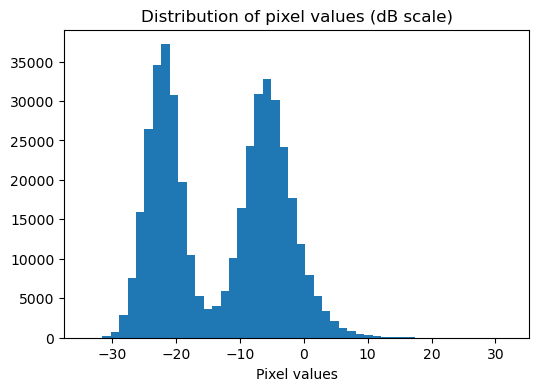

In [43]:
fig, ax = plt.subplots(figsize=(6, 4))


def db_scale(x):
    return 10 * np.log10(x)


db_scale(vv).plot.hist(bins=50, ax=ax)
ax.set(title="Distribution of pixel values (dB scale)", xlabel="Pixel values");

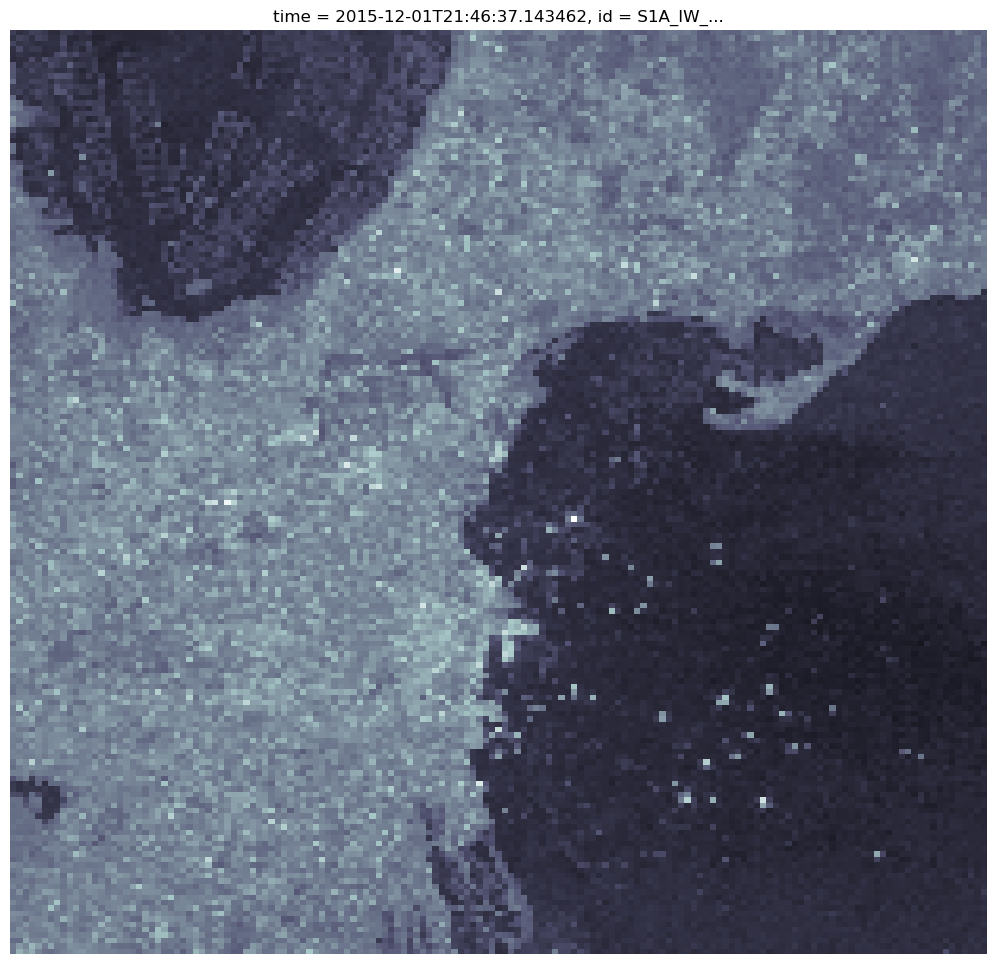

In [44]:
img = (
    db_scale(vv)
    .coarsen(x=4, y=4, boundary="trim")
    .max()
    .plot.imshow(cmap="bone", size=12, aspect=1.05, add_colorbar=False)
)
img.axes.set_axis_off();

In [49]:
rtc_item = catalog.get_collection("sentinel-1-rtc").get_item(
    "S1A_IW_GRDH_1SDV_20151213T214624_20151213T214649_009029_00CF3B_rtc"
)
grd_item = pystac.read_file(rtc_item.get_single_link("derived_from").target)

In [50]:
grd_tiles = requests.get(grd_item.assets["tilejson"].href).json()["tiles"][0]
rtc_tiles = requests.get(rtc_item.assets["tilejson"].href).json()["tiles"][0]

In [52]:
center = [14.65679074588396, 121.04031202696218]
m = ipyleaflet.Map(
    center=center,
    zoom=14,
    controls=[ipyleaflet.FullScreenControl()],
)
grd_layer = ipyleaflet.TileLayer(url=grd_tiles)
rtc_layer = ipyleaflet.TileLayer(url=rtc_tiles)

control = ipyleaflet.SplitMapControl(left_layer=grd_layer, right_layer=rtc_layer)
m.add_control(control)
m.scroll_wheel_zoom = True
m


Map(center=[14.65679074588396, 121.04031202696218], controls=(FullScreenControl(options=['position']), ZoomCon…

### Conclusion